# Youtube Watch History Exploratory Data Analysis 

## Alberto Aldapa

### Data from Google Takeout

In [1]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import dateutil
import random
import argparse
import isodate
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import requests
import time
import numpy as np
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
api_key = ''
f = open(r'C:\Users\Alberto\Desktop\Data Analytics\youtube_history_project\watch-history.json', encoding="UTF-8")
history = json.load(f)
history_list = []
total_videos = len(history)
for i in range(0,len(history)):
    if history[i]['header'] == 'YouTube':
        if 'titleUrl' in history[i]:
            video = history[i]['titleUrl'].split('=',1)[1]
            view_date = history[i]['time']
            history_list.append(dict(
                watch_date = view_date,
                video_id = video
            
            
            ))


youtube = build('youtube', 'v3', developerKey=api_key)

# How many videos have I watched?

In [4]:
print(len(history_list))

11671


# What is the range of the data?

### OCT 10th, 2020 to DEC 12th, 2022

In [5]:
history_list[-1]['watch_date']

'2020-10-05T23:56:39.198Z'

In [6]:
history_list[0]['watch_date']

'2022-12-10T04:27:09.950Z'

# Function to extract video data using video_id

In [7]:
def get_video_stats(youtube, sample_list):
    all_data = []
    all_ids = [sub['video_id'] for sub in sample_list]
    batched_ids = []
    n = 50
    for i in range(0,len(all_ids),n):
        batched_ids.append(all_ids[i:i + n])
    
    for i in range(len(batched_ids)):
        request = youtube.videos().list(
                    part='snippet,contentDetails,statistics',
                    id=batched_ids[i])
                    #id=[sub['video_id'] for sub in history_list])

        response = request.execute()

        for i in range(len(response["items"])):
            data = dict(video_id = response["items"][i]["id"],
                    video_title = response["items"][i]["snippet"]['title'],
                    video_description = response["items"][i]["snippet"]['description'],
                    published_at = response["items"][i]["snippet"]['publishedAt'],
                    channel_id = response["items"][i]["snippet"]['channelId'],
                    category_id = response["items"][i]["snippet"]['categoryId'],
                    duration = response["items"][i]["contentDetails"]['duration'],
                    favorite_count = response["items"][i]["statistics"]['favoriteCount']
                    )
            if 'tags' in response["items"][i]["snippet"]:
             data['tag'] = response["items"][i]["snippet"]['tags']
            else:
             data['tag'] = 'NULL'
            
            if 'likeCount' in response["items"][i]["statistics"]:
             data['like_count'] = response["items"][i]["statistics"]['likeCount']
            else:
             data['like_count'] = 'NULL'
            
            if 'commentCount' in response["items"][i]["statistics"]:
             data['comment_count'] = response["items"][i]["statistics"]['commentCount']
            else:
             data['comment_count'] = 'NULL'
            
            if 'viewCount' in response["items"][i]["statistics"]:
             data['view_count'] = response["items"][i]["statistics"]['viewCount']
            else:
             data['view_count'] = 'NULL'
            if data['video_title'] is None:
                print(i)
            all_data.append(data)
    return all_data

In [8]:
video_stats = get_video_stats(youtube, history_list)
#print(video_stats)

In [9]:
video_data = pd.DataFrame(video_stats)

In [10]:
video_view = pd.DataFrame(history_list)

# How many viewed videos have been taken down?

In [11]:
final_data = video_view.merge(video_data, how='left', on='video_id')
final_data[final_data['video_title'].isna()].count()

watch_date           355
video_id             355
video_title            0
video_description      0
published_at           0
channel_id             0
category_id            0
duration               0
favorite_count         0
tag                    0
like_count             0
comment_count          0
view_count             0
dtype: int64

# Cleaning Data

In [12]:
final_data_clean = final_data.dropna().copy() #Remove NAs
final_data_clean = final_data_clean.drop_duplicates(['watch_date']) #remove duplicates
final_data_clean

,watch_date,video_id,video_title,video_description,published_at,channel_id,category_id,duration,favorite_count,tag,like_count,comment_count,view_count
0,2022-12-10T04:27:09.950Z,gwp3dJUsy5g,SQL for Data Analysts and Data Scientists IN 1...,"PRACTICE SQL, AND PYTHON HERE: https://stratas...",2021-05-21T02:07:55Z,UCvZnwzmc3m1Eush-Or8Z6DA,28,PT53M20S,0,NULL,12437,328,298852
1,2022-12-10T02:16:04.642Z,ZfN8nG0luig,RECESSION 2023: Should You Worry About Data Sc...,🤓 Join my Discord server: \nhttps://discord.gg...,2022-12-05T23:40:57Z,UCJQJAI7IjbLcpsjWdSzYz0Q,22,PT16M25S,0,"[data analytics, data science, python, data, t...",1675,90,40319
2,2022-12-09T23:37:43.707Z,D9oP2TqZiMo,Craft a WINNING Data Analyst Resume,Are you having trouble standing out in sea of ...,2021-11-21T00:33:11Z,UCvZnwzmc3m1Eush-Or8Z6DA,27,PT40M22S,0,NULL,765,29,14069
4,2022-12-09T22:37:35.092Z,sSnbmbRmtSA,Data Cleaning CHALLENGE (can you think of a be...,Let's try and clean some data. This is an anon...,2021-09-14T14:00:12Z,UCvZnwzmc3m1Eush-Or8Z6DA,27,PT22M41S,0,NULL,3726,195,126305
5,2022-12-09T15:10:23.925Z,cIZWgPmpRVc,Get NOTICED in Data Science!!! (3 types of GRE...,"In this video, we talk with John Boudreaux, a ...",2021-08-17T11:00:12Z,UCLLw7jmFsvfIVaUFsLs8mlQ,28,PT8M1S,0,"[data viz by luke, business intelligence, data...",4627,175,84174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16077,2020-10-06T04:35:59.157Z,e-P5IFTqB98,Black Holes Explained – From Birth to Death,Black holes. Lets talk about them.\n\n\nOUR CH...,2015-12-15T16:33:55Z,UCsXVk37bltHxD1rDPwtNM8Q,27,PT5M56S,0,"[black hole, universe, space, cosmos, earth, d...",366410,16755,21784735
16078,2020-10-06T04:35:49.671Z,i2u-7LMhwvE,Simulation Reveals Spiraling Supermassive Blac...,A new model is bringing scientists a step clos...,2018-10-02T15:01:23Z,UCAY-SMFNfynqz1bdoaV8BeQ,28,PT2M14S,0,"[Simulation, X-ray, Black Hole, Astrophysics, ...",6187,503,558411
16080,2020-10-06T04:34:14.725Z,0zi7evq0gHA,Super-Detailed Black Hole Simulations Solved A...,Black holes in space are a source of both grea...,2019-07-08T15:30:34Z,UCeY0bbntWzzVIaj2z3QigXg,25,PT1M51S,0,"[Mach, Space, Latest Stories, NBC, NBC News, N...",225,31,29676
16081,2020-10-05T23:57:00.538Z,IHRtS-5OJVA,ASMR show: Testing ESP ability with Russell Ta...,The ESP trainer was developed under a NASA pro...,2020-02-03T19:15:00Z,UCE0syqEmsR1Ys-92jSPQO6w,23,PT7M55S,0,"[asmr show, asmr.show, asmrshow, asmr, acmp, a...",82,31,9333


# Converting Data Types

In [13]:
numeric_cols = ['view_count','like_count','favorite_count','comment_count']
final_data_clean[numeric_cols] = final_data_clean[numeric_cols].apply(pd.to_numeric,
                                                                      errors='coerce',axis = 1) # from object to number


final_data_clean['watch_date'] = pd.to_datetime(final_data_clean['watch_date'],
                                                infer_datetime_format=True) # from object to Date
final_data_clean['published_at'] = pd.to_datetime(final_data_clean['published_at'],
                                                  infer_datetime_format=True) # from object to Date

final_data_clean['duration_sec'] = final_data_clean['duration'].apply(lambda x: isodate.parse_duration(x)) # new column for Duration in seconds

final_data_clean['duration_sec'] = final_data_clean['duration_sec'].astype('timedelta64[s]') # conversion from int to type seconds
final_data_clean.dtypes

watch_date           datetime64[ns, UTC]
video_id                          object
video_title                       object
video_description                 object
published_at         datetime64[ns, UTC]
channel_id                        object
category_id                       object
duration                          object
favorite_count                   float64
tag                               object
like_count                       float64
comment_count                    float64
view_count                       float64
duration_sec                     float64
dtype: object

# How clean does our data look so far?

In [14]:
final_data_clean.isnull().any()

watch_date           False
video_id             False
video_title          False
video_description    False
published_at         False
channel_id           False
category_id          False
duration             False
favorite_count       False
tag                  False
like_count            True
comment_count         True
view_count            True
duration_sec         False
dtype: bool

In [15]:
final_data_clean.describe()

,favorite_count,like_count,comment_count,view_count,duration_sec
count,11316.0,1.123900e+04,1.119200e+04,1.130700e+04,1.131600e+04
mean,0.0,6.314905e+04,4.276748e+03,3.273319e+06,3.097731e+04
std,0.0,5.540788e+05,1.106599e+05,5.866781e+07,1.302562e+06
min,0.0,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00
25%,0.0,6.625000e+02,7.300000e+01,3.516450e+04,3.880000e+02
50%,0.0,4.197000e+03,3.750000e+02,1.648800e+05,6.670000e+02
75%,0.0,2.393100e+04,1.740250e+03,9.829370e+05,1.069000e+03
max,0.0,4.031744e+07,1.121074e+07,5.798593e+09,7.503743e+07


# What is my favorite Category?

In [16]:
final_data_groupedby_category = final_data_clean.groupby(['category_id'])['category_id'].size().reset_index(name='counts')
final_data_groupedby_category = final_data_groupedby_category.sort_values(by=['counts'],ascending=False).reset_index(drop=True)

final_data_groupedby_category['category_id'] = final_data_groupedby_category['category_id'].replace(['2', '1','10','15','17','18','19','20','21','22','23','24','25',
                                                                                      '26','27','28','29','30','31','32','33','34','35','36','37',
                                                                                      '38','39','40','41','42','43','44'],[
                'Autos & Vehicles','Film & Animation', 'Music', 'Pets & Animals', 'Sports', 'Short Movies', 
                'Travel & Events', 'Gaming', 'Videoblogging', 'People & Blogs', 'Comedy', 'Entertainment', 
                'News & Politics', 'How to & Style', 'Education', 'Science & Technology', 'Nonprofits & Activism', 'Movies', 
                'Anime/Animation', 'Action/Adventure', 'Classics','Comedy', 'Documentary', 'Drama', 'Family', 'Foreign', 
                'Horror', 'Sci-Fi/Fantasy', 'Thriller', 'Shorts', 'Shows', 'Trailers'])

#final_data_groupedby_category

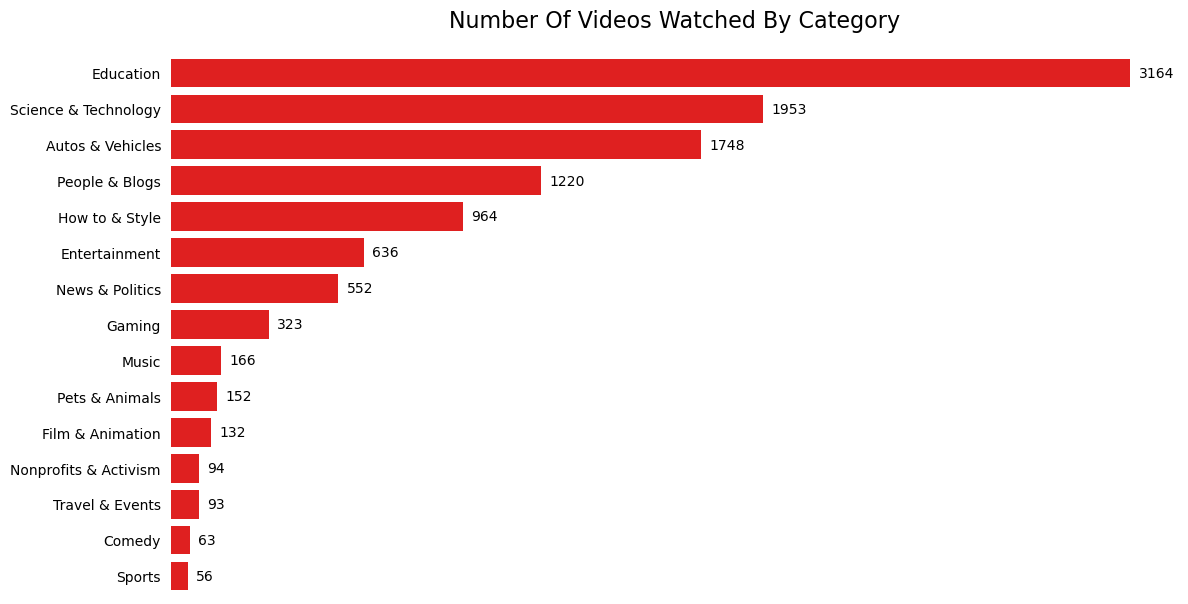

In [17]:
'''%matplotlib notebook
fig = plt.figure(figsize=(9.5,6))



def animate(i):
    data = final_data_groupedby_category.iloc[:int(i+1)] 
    ax = sns.barplot(y='category_id', x='counts',data=final_data_groupedby_category, orient='horizontal')
    for i in ax.containers:
        ax.bar_label(i,)
        
    plt.ylabel('Category')
    plt.xlabel('Count')
    
ani = anim.FuncAnimation(fig, animate,repeat=False)
plt.xticks(range(0,50,5))
plt.yticks(rotation=60)
plt.show()'''
fig = plt.figure(figsize=(13,7))

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

ax = sns.barplot(y='category_id', x='counts',data=final_data_groupedby_category, orient='horizontal', color='#FF0000')
#plt.yticks(rotation=20)
plt.ylabel('',labelpad=20,fontdict=font)
plt.xlabel('',labelpad=20,fontdict=font)
plt.title('Number Of Videos Watched By Category',fontdict=font,pad=20)
for i in ax.containers:
        ax.bar_label(i,padding=6,)
        
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=True)

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

plt.show()
fig.savefig("favoriteCategory.png", bbox_inches='tight', pad_inches=0.4, dpi=600)

# Whats my favorite day to watch YouTube?

In [18]:
day_data = final_data_clean.copy()
day_data['watch_date'] = day_data['watch_date'].dt.day_name()
#final_data

In [19]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

final_data_groupedby_watch_day = day_data.groupby(['watch_date'])['watch_date'].size().reset_index(name='count')
final_data_groupedby_watch_day['watch_date'] = pd.Categorical(final_data_groupedby_watch_day['watch_date'],
                                                              categories=days, ordered=True)
final_data_groupedby_watch_day = final_data_groupedby_watch_day.sort_values('watch_date')


In [20]:
final_data_groupedby_watch_day

,watch_date,count
1,Monday,1620
5,Tuesday,1877
6,Wednesday,1809
4,Thursday,1658
0,Friday,1612
2,Saturday,1372
3,Sunday,1368


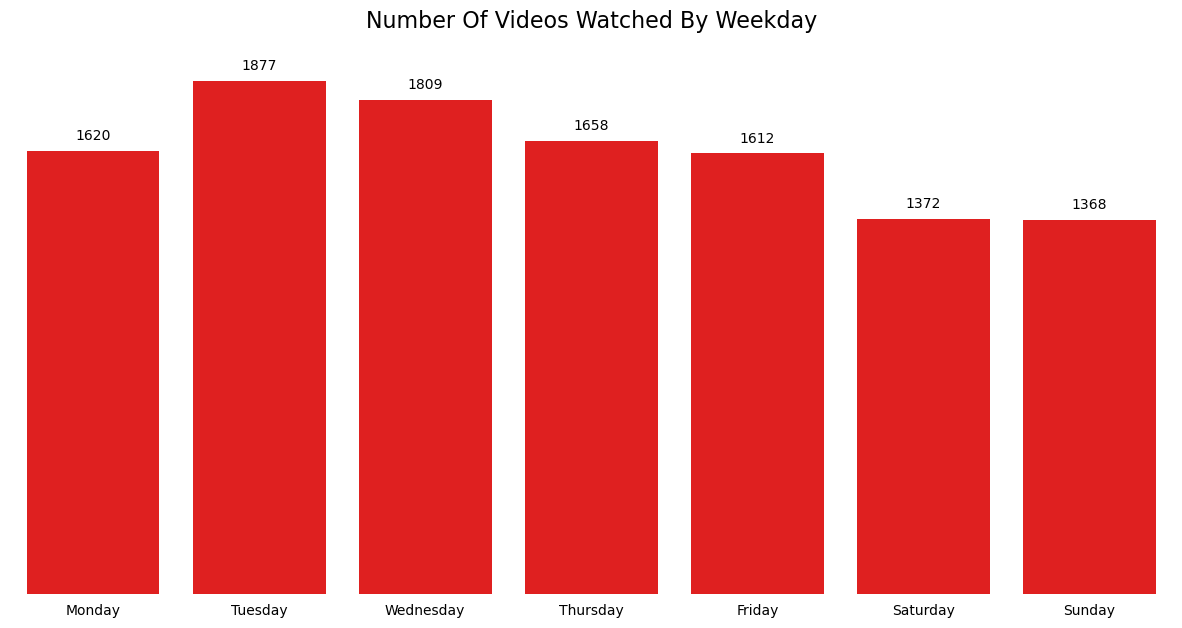

In [21]:
fig = plt.figure(figsize=(15,7))
font = {'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
fav_day = sns.barplot(y='count', x='watch_date',data=final_data_groupedby_watch_day,color='#FF0000')
for i in fav_day.containers:
        fav_day.bar_label(i,padding=6,)
#plt.xticks(rotation=20)
plt.ylabel('',labelpad=20,fontdict=font)
plt.xlabel('',labelpad=20,fontdict=font)
plt.title('Number Of Videos Watched By Weekday',pad=20,fontdict=font)

plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

plt.show()
fig.savefig("favoriteWatchDay.png", bbox_inches='tight', pad_inches=0.4, dpi=600)

# What week did I watch more videos last year?

In [22]:
copy = final_data_clean.copy()
ttone = copy[final_data_clean['watch_date'].dt.year == 2021]
by_week = ttone.sort_values(by='watch_date',ascending=True).reset_index(drop=True)
by_week['week_num'] = by_week['watch_date'].dt.strftime('%U')
#by_week
#watch_trend = sns.barplot(y='counts', x='watch_date',data=final_data_groupedby_watch_day)

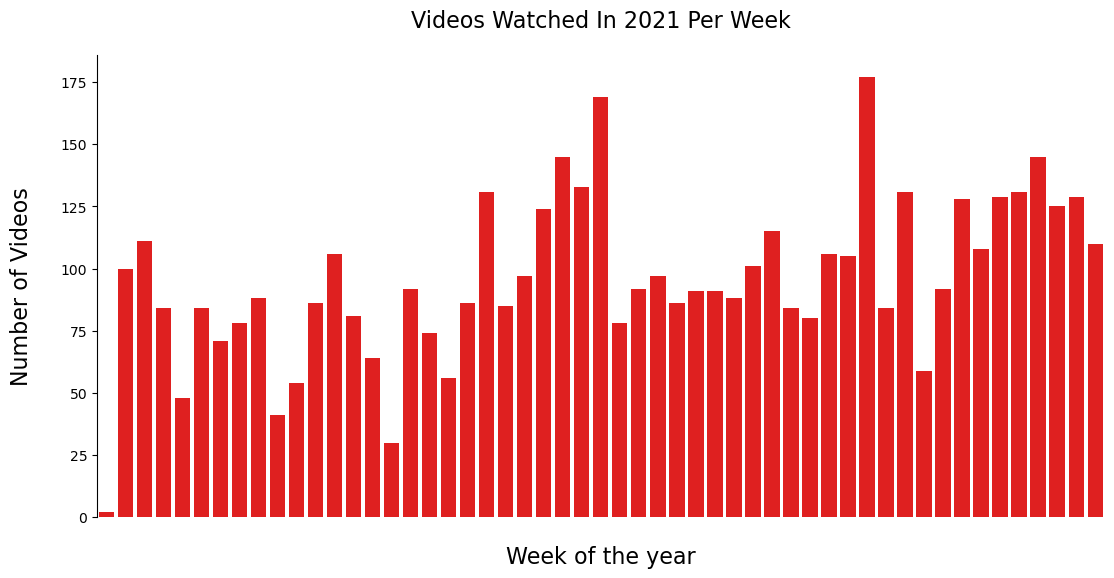

In [23]:
grouped_by_week = by_week.groupby(['week_num'])['week_num'].size().reset_index(name='videos_per_week')
fig = plt.figure(figsize=(13,6))
watch_trend = sns.barplot(y='videos_per_week', x='week_num',data=grouped_by_week,color='#FF0000')
plt.title('Videos Watched In 2021 Per Week',pad=20,fontdict=font)
plt.ylabel('Number of Videos',labelpad=20,fontdict=font)
plt.xlabel('Week of the year',labelpad=20,fontdict=font)
plt.xticks(rotation=90)
watch_trend.set(xticklabels=[])

plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

for pos in ['top', 'bottom','right']:
    plt.gca().spines[pos].set_visible(False)


plt.show()
fig.savefig("2021Trend.png", bbox_inches='tight', pad_inches=0.4, dpi=600)

# What is the average length of the videos I have watched?

In [24]:
#final_data_clean

In [25]:
by_duration = final_data_clean.sort_values(by='duration_sec',ascending=False).reset_index(drop=True)
by_duration = by_duration[by_duration['duration_sec'] < 14400]
by_duration['duration_min'] = by_duration['duration_sec'].div(60).round(2)
#by_duration

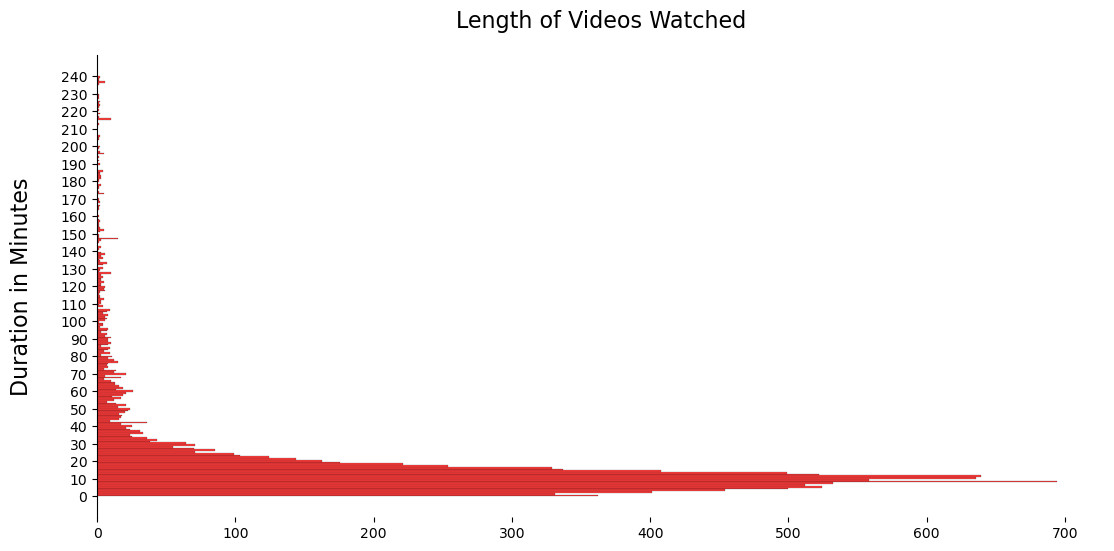

In [26]:
fig = plt.figure(figsize=(13,6))
watch_length = sns.histplot(y='duration_min',data=by_duration,color='#FF0000',orientation='horizontal')
plt.ylabel('Duration in Minutes',labelpad=20,fontdict=font)
plt.xlabel('',labelpad=20,fontdict=font)
plt.title('Length of Videos Watched',pad=20,fontdict=font)
plt.yticks(range(0,250,10))
#plt.xticks(rotation=90)

plt.tick_params(axis='y', which='both', right=False,
                left=True, labelleft=True)
plt.tick_params(axis='x', which='both', right=False,
                bottom=True, labelbottom=True)

for pos in ['right', 'top', 'bottom']:
    plt.gca().spines[pos].set_visible(False)

plt.show()
fig.savefig("distributionOfVideoLength.png", bbox_inches='tight', pad_inches=0.4, dpi=600)

# What words are most common in the title of videos I have watched?

In [27]:
final_data_clean

,watch_date,video_id,video_title,video_description,published_at,channel_id,category_id,duration,favorite_count,tag,like_count,comment_count,view_count,duration_sec
0,2022-12-10 04:27:09.950000+00:00,gwp3dJUsy5g,SQL for Data Analysts and Data Scientists IN 1...,"PRACTICE SQL, AND PYTHON HERE: https://stratas...",2021-05-21 02:07:55+00:00,UCvZnwzmc3m1Eush-Or8Z6DA,28,PT53M20S,0.0,NULL,12437.0,328.0,298852.0,3200.0
1,2022-12-10 02:16:04.642000+00:00,ZfN8nG0luig,RECESSION 2023: Should You Worry About Data Sc...,🤓 Join my Discord server: \nhttps://discord.gg...,2022-12-05 23:40:57+00:00,UCJQJAI7IjbLcpsjWdSzYz0Q,22,PT16M25S,0.0,"[data analytics, data science, python, data, t...",1675.0,90.0,40319.0,985.0
2,2022-12-09 23:37:43.707000+00:00,D9oP2TqZiMo,Craft a WINNING Data Analyst Resume,Are you having trouble standing out in sea of ...,2021-11-21 00:33:11+00:00,UCvZnwzmc3m1Eush-Or8Z6DA,27,PT40M22S,0.0,NULL,765.0,29.0,14069.0,2422.0
4,2022-12-09 22:37:35.092000+00:00,sSnbmbRmtSA,Data Cleaning CHALLENGE (can you think of a be...,Let's try and clean some data. This is an anon...,2021-09-14 14:00:12+00:00,UCvZnwzmc3m1Eush-Or8Z6DA,27,PT22M41S,0.0,NULL,3726.0,195.0,126305.0,1361.0
5,2022-12-09 15:10:23.925000+00:00,cIZWgPmpRVc,Get NOTICED in Data Science!!! (3 types of GRE...,"In this video, we talk with John Boudreaux, a ...",2021-08-17 11:00:12+00:00,UCLLw7jmFsvfIVaUFsLs8mlQ,28,PT8M1S,0.0,"[data viz by luke, business intelligence, data...",4627.0,175.0,84174.0,481.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16077,2020-10-06 04:35:59.157000+00:00,e-P5IFTqB98,Black Holes Explained – From Birth to Death,Black holes. Lets talk about them.\n\n\nOUR CH...,2015-12-15 16:33:55+00:00,UCsXVk37bltHxD1rDPwtNM8Q,27,PT5M56S,0.0,"[black hole, universe, space, cosmos, earth, d...",366410.0,16755.0,21784735.0,356.0
16078,2020-10-06 04:35:49.671000+00:00,i2u-7LMhwvE,Simulation Reveals Spiraling Supermassive Blac...,A new model is bringing scientists a step clos...,2018-10-02 15:01:23+00:00,UCAY-SMFNfynqz1bdoaV8BeQ,28,PT2M14S,0.0,"[Simulation, X-ray, Black Hole, Astrophysics, ...",6187.0,503.0,558411.0,134.0
16080,2020-10-06 04:34:14.725000+00:00,0zi7evq0gHA,Super-Detailed Black Hole Simulations Solved A...,Black holes in space are a source of both grea...,2019-07-08 15:30:34+00:00,UCeY0bbntWzzVIaj2z3QigXg,25,PT1M51S,0.0,"[Mach, Space, Latest Stories, NBC, NBC News, N...",225.0,31.0,29676.0,111.0
16081,2020-10-05 23:57:00.538000+00:00,IHRtS-5OJVA,ASMR show: Testing ESP ability with Russell Ta...,The ESP trainer was developed under a NASA pro...,2020-02-03 19:15:00+00:00,UCE0syqEmsR1Ys-92jSPQO6w,23,PT7M55S,0.0,"[asmr show, asmr.show, asmrshow, asmr, acmp, a...",82.0,31.0,9333.0,475.0


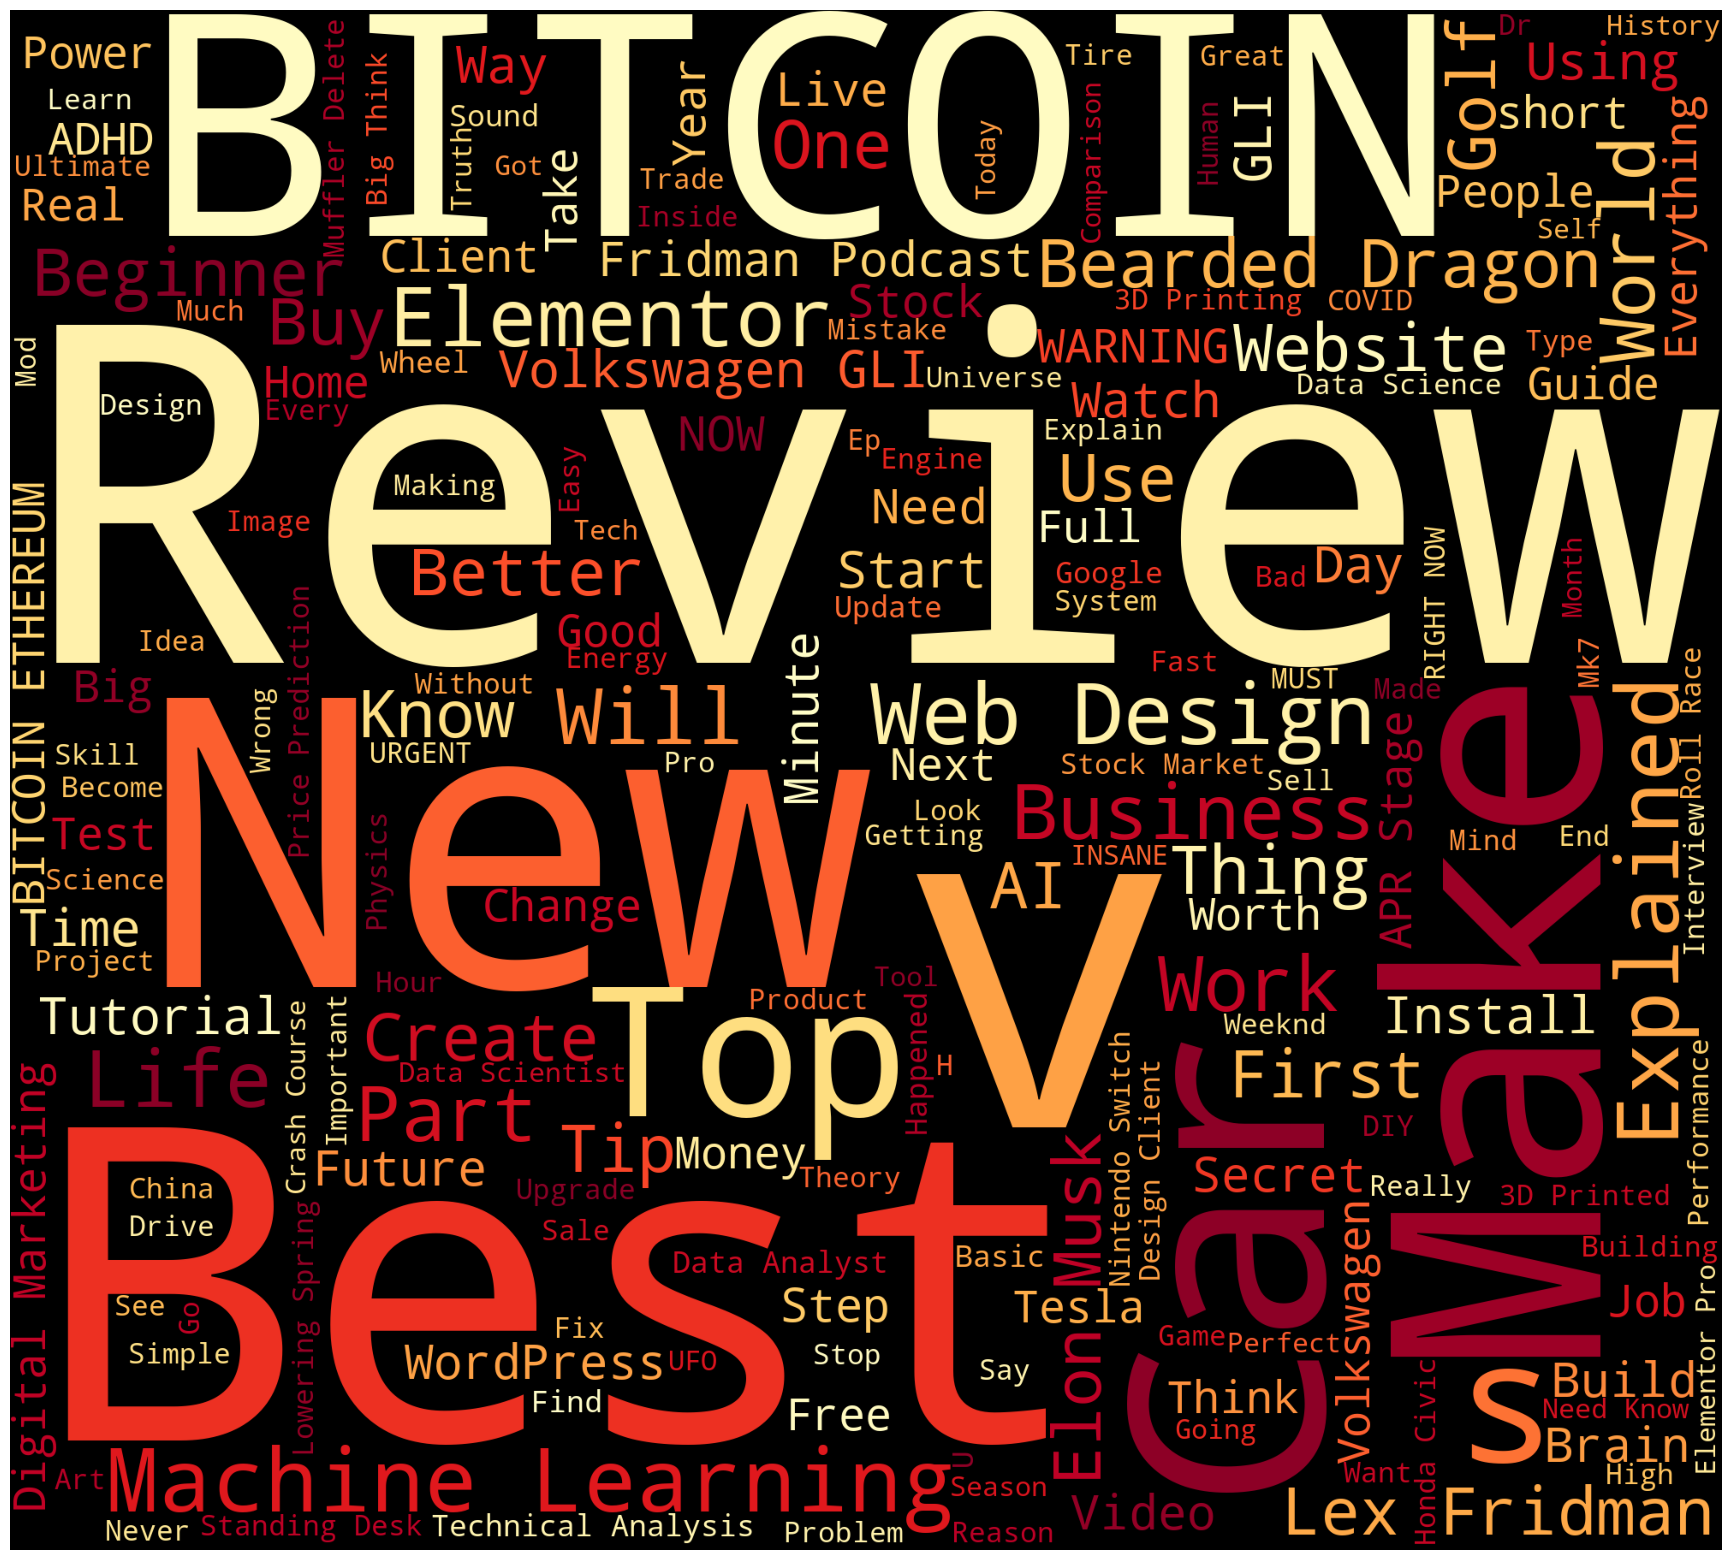

In [28]:
stop_words = set(stopwords.words('english'))
stop_words.update(['MK7','Jetta','GTI','VW','Thing','V','v','W','U','L','L','t','W1','H','u','>','<'])
final_data_clean['title_no_stopwords'] = final_data_clean['video_title'].apply(lambda x:[item for item in str(x).split() 
                                                                                        if item not in stop_words]).copy()

all_words = list([a for b in final_data_clean['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

#all_words.remove('v')

def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1800, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=True).generate(all_words_str)
plot_cloud(wordcloud)

# What are the most common words in the discription of videos I have watched?

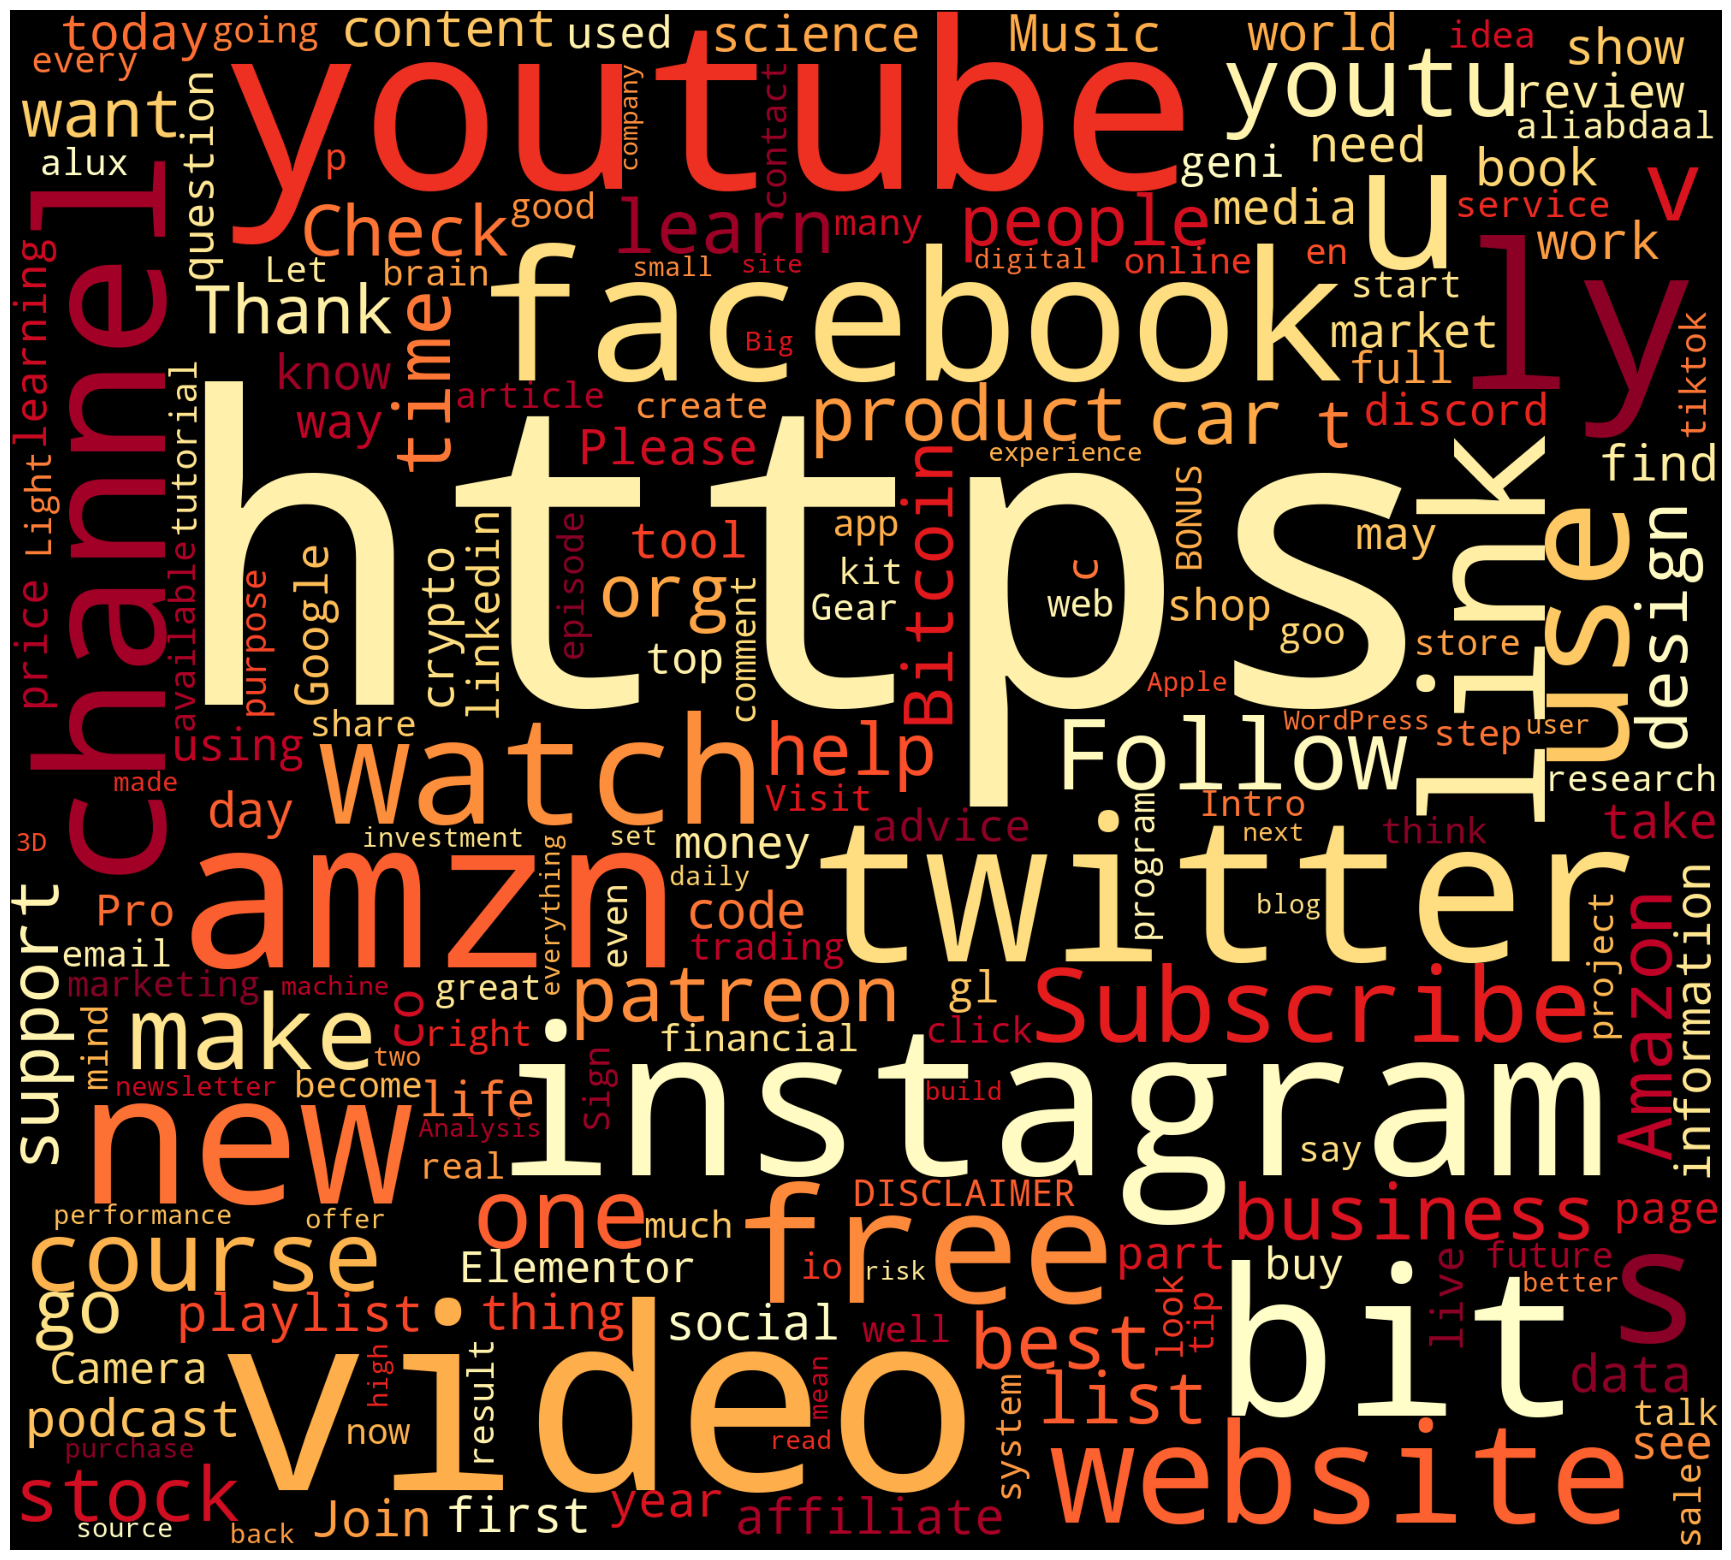

In [29]:
final_data_clean['desciption_no_stopwords'] = final_data_clean['video_description'].apply(lambda x:[item for item in str(x).split() 
                                                                                        if item not in stop_words]).copy()

all_words1 = list([a for b in final_data_clean['desciption_no_stopwords'].tolist() for a in b])
all_words_str1 = ' '.join(all_words1)

wordcloud1 = WordCloud(width = 2000, height = 1800, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(all_words_str1)
plot_cloud(wordcloud1)

# Whats my favorite Youtuber?

In [30]:
final_data_groupedby_channel = final_data_clean[final_data_clean['duration_sec'] < 14400].copy()
final_data_groupedby_channel['duration_min'] = final_data_groupedby_channel['duration_sec'].div(60).round(2)
final_data_groupedby_channel = final_data_groupedby_channel.groupby(['channel_id'])['duration_min'].sum().reset_index(name='sum')
final_data_groupedby_channel = final_data_groupedby_channel.sort_values(by=['sum'],ascending=False).reset_index(drop=True)
final_data_groupedby_channel = final_data_groupedby_channel[final_data_groupedby_channel['sum'] > 2000]
final_data_groupedby_channel

def get_channel_title(cid):
    request1 = youtube.channels().list(
                    part='snippet,contentDetails,statistics',
                    id=cid)
                    

    response = request1.execute()
    title = response['items'][0]['snippet']['title']
    return title

#channel_title = get_channel_title('UC7lb7-6SLqw-wiJlq3LMy2A')
final_data_groupedby_channel['channel_title'] = final_data_groupedby_channel['channel_id'].apply(get_channel_title)
final_data_groupedby_channel

,channel_id,sum,channel_title
0,UCSHZKyawb77ixDdsGog4iWA,12395.74,Lex Fridman
1,UCXmAl7cO_eWT_JFxgI74lgA,3184.08,J Bravo
2,UC2D2CMWXMOVWx7giW1n3LIg,3073.57,Andrew Huberman
3,UCgeicB5AuF3MyyUto0-M5Lw,3049.72,Actualized.org
4,UCBkGMys0mYl3Myxh3CTsASA,2558.35,MMCrypto
5,UCHOP_YfwdMk5hpxbugzC1wA,2421.92,Chart Champions
6,UCm_WkN0wg49-eG4SymAQ_4g,2370.37,Harvard Innovation Labs
7,UCVEQTVuaFpcatHDhKIyhZmQ,2306.64,BitcoinHyper
8,UCZpkfpfGe2ZC3AIQ69ERCJw,2278.66,Ferdy Korpershoek


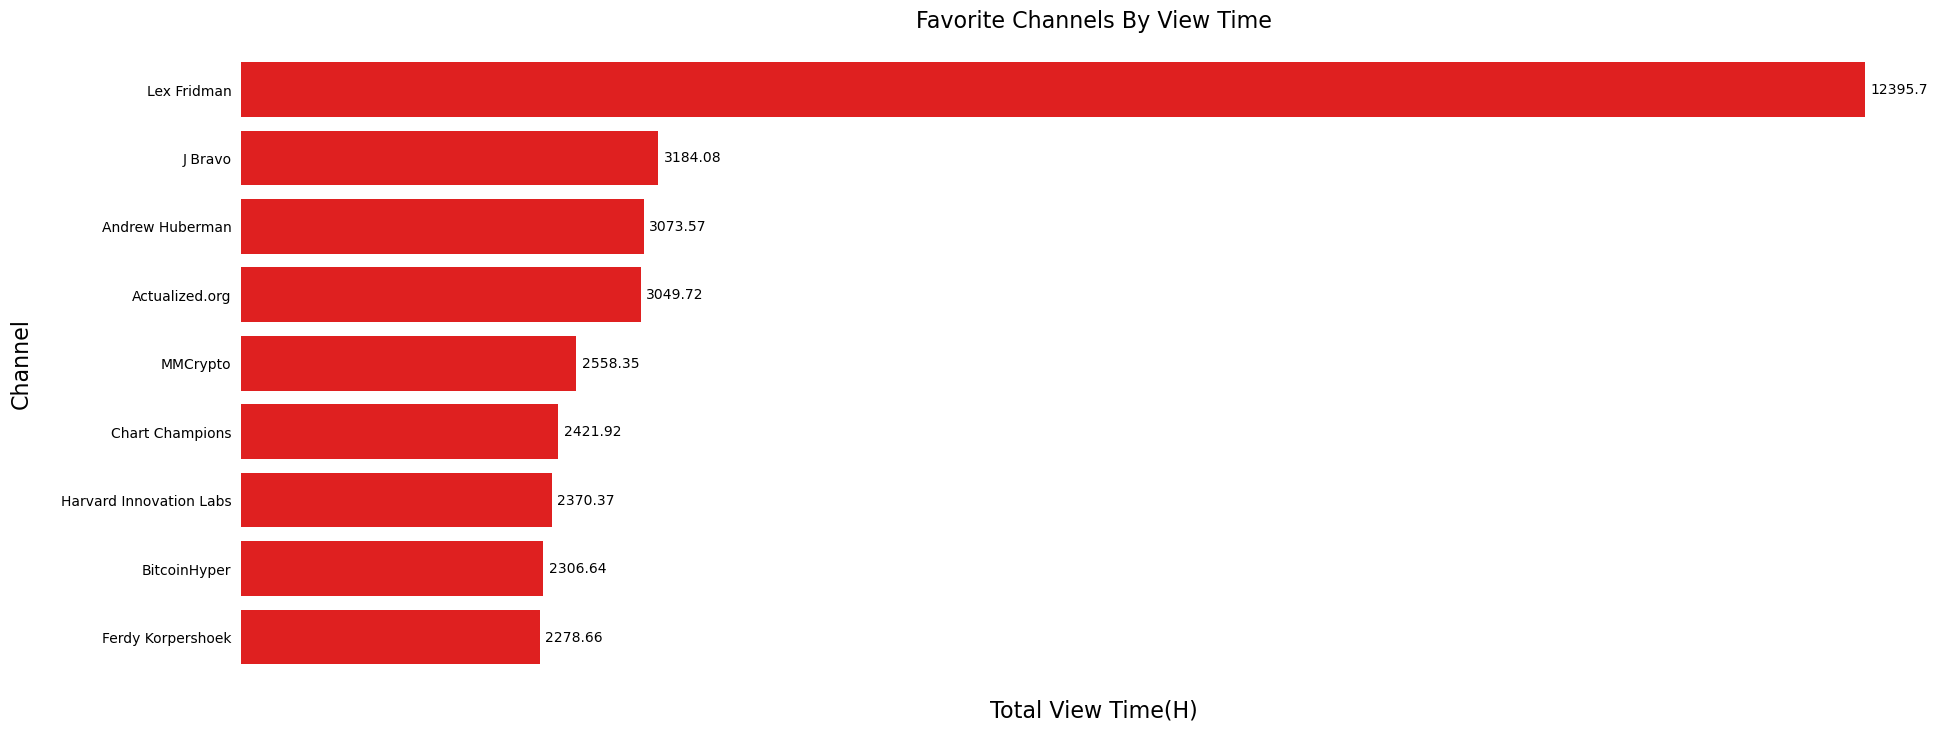

In [31]:
fig = plt.figure(figsize=(22,8))
watch_trend = sns.barplot(y='channel_title', x='sum',data=final_data_groupedby_channel,orient='horizontal',color='#FF0000')
plt.title('Favorite Channels By View Time',pad=20,fontdict=font)
plt.ylabel('Channel',labelpad=20,fontdict=font)
plt.xlabel('Total View Time(H)',labelpad=20,fontdict=font)
plt.xticks(rotation=80)
for i in watch_trend.containers:
        watch_trend.bar_label(i,padding=4,)
#watch_trend.set(xticklabels=[])

plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=True)

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

plt.show()
fig.savefig("favoriteChannel.png", bbox_inches='tight', pad_inches=0.4, dpi=600)

# Which videos have I rewatched the most?

In [32]:
final_data_grouped_by_video = final_data_clean.groupby(['video_title'])['video_title'].count().reset_index(name='video_count')
final_data_grouped_by_video = final_data_grouped_by_video.sort_values(by=['video_count'],ascending=False).reset_index(drop=True)
final_data_grouped_by_video.head(20)

,video_title,video_count
0,Make An Appointment Booking Website Using JetA...,13
1,How to Get Rich,9
2,"VOLKSWAGEN JETTA GLI // MBRP 3"" Cat-Back, Dual...",9
3,"MK7 VW Jetta GLI MBRP 3"" Catback exhaust | Col...",8
4,VIOFO A129 DUO (and A119 V3) Hardwire Installa...,8
5,ProductRundown: Exhaust Suite for the VW MK7 GLI,8
6,How to Perform Your Own Fecal Exam - Reptiles,7
7,VW Jetta GLI APR Stage 1,7
8,2019 VW Jetta GLI Review - GTI With a Trunk,7
9,Learn Fusion 360 or Die Trying LESSON 6: Sketc...,7


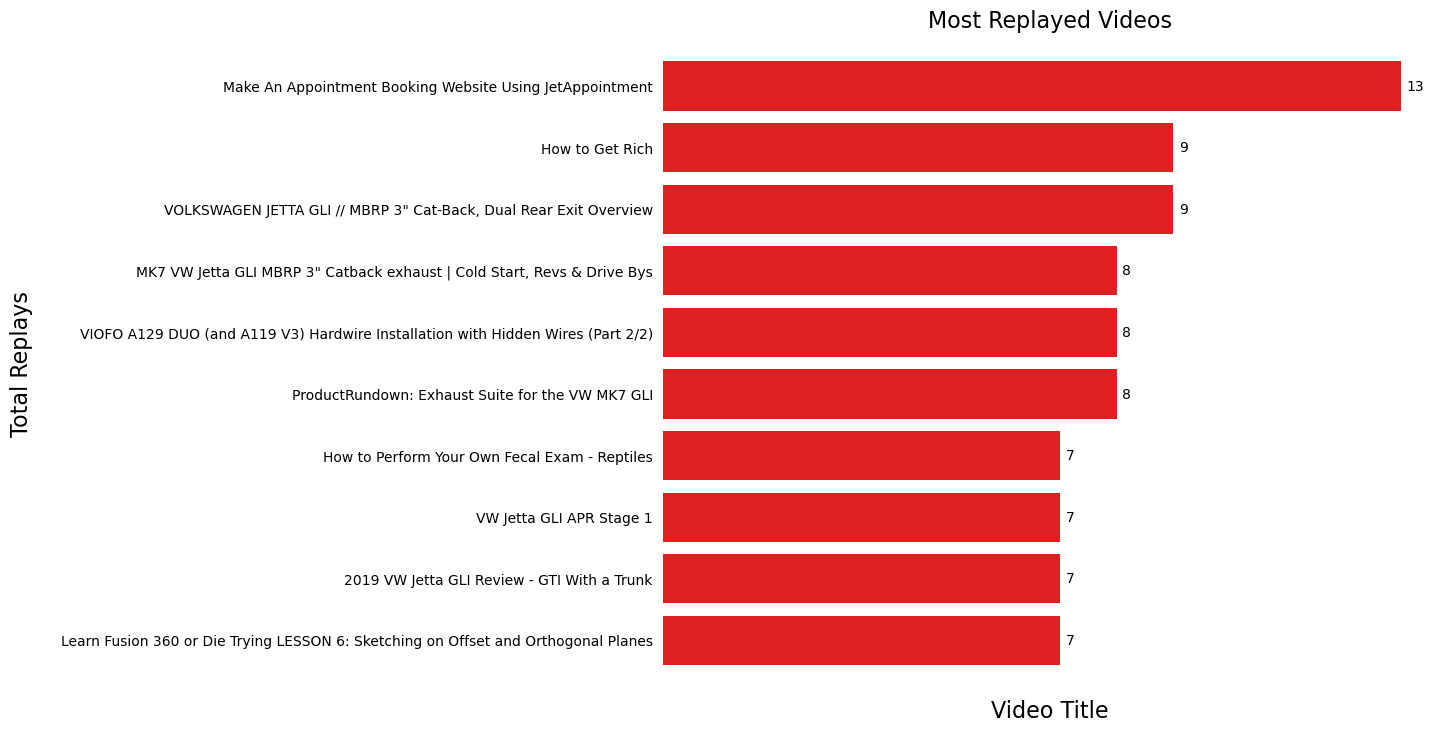

In [33]:
fig = plt.figure(figsize=(10,8))
watch_count = sns.barplot(y='video_title', x='video_count',data=final_data_grouped_by_video.head(10),orient='horizontal',color='#FF0000')
plt.title('Most Replayed Videos',pad=20,fontdict=font)
plt.ylabel('Total Replays',labelpad=20,fontdict=font)
plt.xlabel('Video Title',labelpad=20,fontdict=font)
#plt.xticks(rotation=80)
for i in watch_count.containers:
        watch_count.bar_label(i,padding=4,)
watch_trend.set(xticklabels=[])

plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=True)

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

plt.show()
fig.savefig("mostReplayed.png", bbox_inches='tight', pad_inches=0.4, dpi=600)

# Do I watch popular videos?

In [34]:
#final_data_clean = final_data_clean.sort_values(by=['like_count'],ascending=False).reset_index(drop=True)
final_data_clean_with_comments = final_data_clean[final_data_clean['duration_sec'] < 14400]
final_data_clean_with_comments = final_data_clean_with_comments[final_data_clean_with_comments['comment_count'] > 0]
final_data_clean_with_comments = final_data_clean_with_comments[final_data_clean_with_comments['duration_sec'] > 1800]
final_data_clean_with_comments = final_data_clean_with_comments.sort_values(by=['like_count'],ascending=False).reset_index(drop=True)
final_data_clean_with_comments = final_data_clean_with_comments.drop_duplicates(['video_title']) #remove duplicates
test = final_data_clean_with_comments.head(5).copy()
test

,watch_date,video_id,video_title,video_description,published_at,channel_id,category_id,duration,favorite_count,tag,like_count,comment_count,view_count,duration_sec,title_no_stopwords,desciption_no_stopwords
0,2021-05-06 19:42:21.514000+00:00,UwsrzCVZAb8,How Far is Too Far? | The Age of A.I.,Can A.I. make music? Can it feel excitement an...,2019-12-18 17:00:08+00:00,UCqVDpXKLmKeBU_yyt_QkItQ,24,PT34M40S,0.0,"[ai, artificial intelligence, machine learning...",976320.0,35582.0,60563987.0,2080.0,"[How, Far, Too, Far?, |, The, Age, A.I.]","[Can, A.I., make, music?, Can, feel, excitemen..."
2,2021-03-30 22:16:18.544000+00:00,BEWz4SXfyCQ,Joe Rogan Experience #1315 - Bob Lazar & Jerem...,Bob Lazar is a physicist who worked at Los Ala...,2019-06-21 03:00:00+00:00,UCzQUP1qoWDoEbmsQxvdjxgQ,22,PT2H14M45S,0.0,"[Joe Rogan Experience, JRE, Joe, Rogan, podcas...",565974.0,162051.0,49738390.0,8085.0,"[Joe, Rogan, Experience, #1315, -, Bob, Lazar,...","[Bob, Lazar, physicist, worked, Los, Alamos, N..."
4,2021-07-07 06:02:39.803000+00:00,M9v9k77DwoY,I CUT this RANDOM rental property for FREE the...,if you would like to watch this video with no ...,2021-06-12 21:48:12+00:00,UCAMTSVcvh86hOXREOiHnJcQ,24,PT1H52M,0.0,"[Lawn Care Juggernaut, Tulsa Lawn Care, overgr...",511683.0,40702.0,13514724.0,6720.0,"[I, CUT, RANDOM, rental, property, FREE, landl...","[would, like, watch, video, talking, I, made, ..."
5,2021-05-03 21:24:01.511000+00:00,_ArVh3Cj9rw,The Future Of Reasoning,This video was created in partnership with Bil...,2021-04-28 21:53:46+00:00,UC6nSFpj9HTCZ5t-N3Rm3-HA,24,PT30M2S,0.0,NULL,483709.0,35087.0,7911986.0,1802.0,"[The, Future, Of, Reasoning]","[This, video, created, partnership, Bill, Gate..."
7,2022-01-20 03:46:15.172000+00:00,fTbEpGZyseA,Happy Birthday Remix - Best Happy Birthday To You,Happy Birthday Remix - Best Happy Birthday To ...,2018-08-05 18:41:37+00:00,UC4GH5mefYolFXhYxVST82Wg,24,PT56M26S,0.0,"[happy birthday channel, happy birthday, happy...",461621.0,17661.0,127661477.0,3386.0,"[Happy, Birthday, Remix, -, Best, Happy, Birth...","[Happy, Birthday, Remix, -, Best, Happy, Birth..."


In [35]:
video_ids = test['video_id'].values.tolist()
video_ids

['UwsrzCVZAb8', 'BEWz4SXfyCQ', 'M9v9k77DwoY', '_ArVh3Cj9rw', 'fTbEpGZyseA']

# What videos are worth rewatching? 

 ## How to extract comments for each video?

In [36]:
import urllib.request
import urllib.error

In [37]:


def get_video_comments(youtube, sample_list):
    all_comments = []
    all_ids = sample_list
    for i in all_ids:
        try:
            video_comments = []
            request = youtube.commentThreads().list(
                part='snippet',
                maxResults=20,
                videoId=i,
                order='relevance')
                        #id=batched_ids[i])
                        #id=[sub['video_id'] for sub in history_list])

            response = request.execute()
            #response.raise_for_status()
            while len(video_comments) < 20:

                for item in response['items']:
                    comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]

                    video_comments.append(comment)

                if 'nextPageToken' in response:
                    request = youtube.commentThreads().list(
                        part='snippet,id',
                        videoId=i,
                        maxResults=20,
                        order='relevance',
                        pageToken = response['nextPageToken'])

                    response = request.execute()
                else:
                    break
            all_comments.append(video_comments)
        except RuntimeError:
            print('comments diabled')
    return all_comments

In [38]:
st = time.time()
all_comments = get_video_comments(youtube, video_ids)
et = time.time()
et - st

4.0498034954071045

In [39]:
len(all_comments)

5

In [40]:
#all_comments

In [41]:
test['comments'] = all_comments

In [42]:
testComment = 'This is horrible for the competitors. Its so good, it will make them cry'
testComment

'This is horrible for the competitors. Its so good, it will make them cry'

In [43]:
tokens = nltk.word_tokenize(testComment)
tokens[:10]

['This',
 'is',
 'horrible',
 'for',
 'the',
 'competitors',
 '.',
 'Its',
 'so',
 'good']

In [44]:
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('is', 'VBZ'),
 ('horrible', 'JJ'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('competitors', 'NNS'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('so', 'RB'),
 ('good', 'JJ')]

In [45]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  This/DT
  is/VBZ
  horrible/JJ
  for/IN
  the/DT
  competitors/NNS
  ./.
  Its/PRP$
  so/RB
  good/JJ
  ,/,
  it/PRP
  will/MD
  make/VB
  them/PRP
  cry/VB)


# Sentiment Analysis - VADER Sentiment Scoring(Bag of Words) 

In [46]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
sia

## Polarity Scores 

In [48]:
testComment

'This is horrible for the competitors. Its so good, it will make them cry'

In [49]:
sia.polarity_scores(testComment)

{'neg': 0.309, 'neu': 0.515, 'pos': 0.175, 'compound': -0.4327}

# RoBERTa Pretrained Model

In [50]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [51]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [52]:
encoded_text = tokenizer(testComment,return_tensors='tf')
output = model(**encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores  # neg,        nutral,      pos

array([0.44049048, 0.34505737, 0.2144521 ], dtype=float32)

In [53]:
def polarity_scores_roberta(example):
    scores_list = []
    for i in example:
        try:
            #print(i)
            encoded_text = tokenizer(i,return_tensors='tf')
            output = model(**encoded_text)
            scores = output[0][0].numpy()
            scores = softmax(scores)
            score_dict = {
                'roberta_neg' : scores[0],
                'roberta_neu' : scores[1],
                'roberta_pos' : scores[2]
            }
            #print(score_dict)
            scores_list.append(score_dict)
        except RuntimeError:
            print(f'Broke for comment {i}')
    return scores_list

In [54]:
#test.head(1)

In [55]:
#test['comments']

## I need to use my GPU to reduce compute speeds for RoBERTa
### I will do this by using CUDA and CUDNN(https://stackoverflow.com/questions/51002045/how-to-make-jupyter-notebook-to-run-on-gpu)

In [56]:
res = []
for i, row in tqdm(test.iterrows(), total=len(test)):
    text = row['comments']
    res.append(polarity_scores_roberta(text))


  0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
#pd.DataFrame(res).T

## Merge to test dataset

In [58]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
#test['sent'] = res

In [59]:
avg = []
for i in res:
    #listOfDic = i.tolist()[0]
    #print(i)
    df = pd.DataFrame(i)
    avg.append(dict(df.mean()))
test['average_sent'] = avg

In [60]:
def get_positive_score(threeScores): #{'roberta_neg': 0.1434102, 'roberta_neu': 0.260990,...}
    pos_score = threeScores.get("roberta_pos")
    return pos_score

test['positive_score'] = test['average_sent'].map(get_positive_score)
#test

In [61]:
pd.set_option('display.max_colwidth', None)
test = test.sort_values(by=['positive_score'],ascending=False).reset_index(drop=True)
#test['comments']

In [62]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', None)
#test